In [3]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import sys
import matplotlib as mpl
from matplotlib.colors import LogNorm

sys.path.append("../src/")
from tapm import utils

In [2]:
args, y0 = utils.read_params(filename="model_params_HIVandSTI.txt")
lambdaP = 1 / 360  # 1,2,4
betaSTI = 0.008  # 0.0016 *[3, 5, 7]

## All the equations we need to calculate Nobs and Nreal as well as their derivatives with respect to H and P

The equations I took from the Latex (double checked the implementation, but if there were mistakes in the Latex they are also here)

Derivatives Laura calculated by hand, double checked by Philipp and Antonio

In [3]:
# functions we need


def Nobs(P, H):
    return lambdas(P, H) * Is(P, H) + lambdaa(P, H) * Ia(P, H)


def Nreal(P, H):
    return betaSTI * ((1 - m(P, H)) * (1 - P) + P) * S(P, H) * (Is(P, H) + Ia(P, H))


def Is(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"] * Ia(P, H)


def Ia(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return ((args["mu"] + args["gammaT_STI"]) * (1 / R0(P, H) - 1)) / (
            -b(P, H) / args["psi"]
            + args["gamma_STI"]
            - args["gammaT_STI"]
            * (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"])
        )


def S(P, H):
    if R0(P, H) < 1:
        return 1
    else:
        # return a(P,H)/((1-args['psi'])*alpha(P,H)) * Is(P,H)/(Ia(P,H) + Is(P,H))
        return 1 / R0(P, H)


def lambdas(P, H):
    return args["lambda_s"] + lambdaa(P, H)


def lambdaa(P, H):
    return lambdaH(P, H) * (1 - P) + lambdaP * P


def lambdaH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H


def betaHIV(P, H):
    return args["beta_HIV"] * (1 - m(P, H))


def m(P, H):
    return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (
        1 - jnp.exp(-H / args["tau_exp"])
    )


def a(P, H):
    return lambdas(P, H) + args["mu"]


def b(P, H):
    return args["gamma_STI"] + lambdaa(P, H) + args["mu"]


def R0(P, H):
    return args["psi"] * alpha(P, H) / b(P, H) + (1 - args["psi"]) * alpha(P, H) / a(
        P, H
    )


def alpha(P, H):
    return betaSTI * (1 - m(P, H) * (1 - P))

In [4]:
# derivatives of functions
# dx/dy names dx_dy for easier readability


def dNobs_dP(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return (
            Is(P, H) * dlambdas_dP(P, H)
            + Ia(P, H) * dlambdaa_dP(P, H)
            + lambdas(P, H) * dIs_dP(P, H)
            + lambdaa(P, H) * dIa_dP(P, H)
        )


def dNobs_dH(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return (
            Is(P, H) * dlambdas_dH(P, H)
            + Ia(P, H) * dlambdaa_dH(P, H)
            + lambdas(P, H) * dIs_dH(P, H)
            + lambdaa(P, H) * dIa_dH(P, H)
        )


def dNreal_dP(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return betaSTI * S(P, H) * (
            ((1 - m(P, H)) * (1 - P) + P) * (dIs_dP(P, H) + dIa_dP(P, H))
            + (Is(P, H) + Ia(P, H)) * m(P, H)
        ) + Nreal(P, H) / S(P, H) * dS_dP(P, H)


def dNreal_dH(P, H):
    if R0(P, H) < 1:
        return 0
    else:
        return betaSTI * S(P, H) * (
            ((1 - m(P, H)) * (1 - P) + P) * (dIs_dH(P, H) + dIa_dH(P, H))
            + (Is(P, H) + Ia(P, H)) * ((1 - P) * (-dm_dH(P, H)))
        ) + Nreal(P, H) / S(P, H) * dS_dH(P, H)


def dIs_dP(P, H):
    return (
        1 / a(P, H) * (1 - args["psi"]) / args["psi"] * Ia(P, H) * db_dP(P, H)
        + b(P, H)
        * (1 - args["psi"])
        / args["psi"]
        * Ia(P, H)
        * (-1 / (a(P, H)) ** 2)
        * da_dP(P, H)
        + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"] * dIa_dP(P, H)
    )


def dIs_dH(P, H):
    return (
        1 / a(P, H) * (1 - args["psi"]) / args["psi"] * Ia(P, H) * db_dH(P, H)
        + b(P, H)
        * (1 - args["psi"])
        / args["psi"]
        * Ia(P, H)
        * (-1 / (a(P, H)) ** 2)
        * da_dH(P, H)
        + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"] * dIa_dH(P, H)
    )


def dIa_dP(P, H):
    part1 = (
        (args["mu"] + args["gammaT_STI"])
        / (
            -b(P, H) / args["psi"]
            + args["gamma_STI"]
            - args["gammaT_STI"]
            * (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"])
        )
        * (-1 / (R0(P, H)) ** 2)
        * dR0_dP(P, H)
    )
    part2 = (
        ((args["mu"] + args["gammaT_STI"]) * (1 / R0(P, H) - 1))
        / (
            -(
                (
                    b(P, H) / args["psi"]
                    + args["gamma_STI"]
                    - args["gammaT_STI"]
                    * (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"])
                )
                ** 2
            )
        )
        * (
            -1 / args["psi"] * db_dP(P, H)
            - args["gammaT_STI"]
            / a(P, H)
            * (1 - args["psi"])
            / args["psi"]
            * db_dP(P, H)
            + args["gammaT_STI"]
            * b(P, H)
            / (a(P, H)) ** 2
            * (1 - args["psi"])
            / args["psi"]
            * da_dP(P, H)
        )
    )
    return part1 + part2


def dIa_dH(P, H):
    part1 = (
        (args["mu"] + args["gammaT_STI"])
        / (
            -b(P, H) / args["psi"]
            + args["gamma_STI"]
            - args["gammaT_STI"]
            * (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"])
        )
        * (-1 / (R0(P, H)) ** 2)
        * dR0_dH(P, H)
    )
    part2 = (
        ((args["mu"] + args["gammaT_STI"]) * (1 / R0(P, H) - 1))
        / (
            -(
                (
                    b(P, H) / args["psi"]
                    + args["gamma_STI"]
                    - args["gammaT_STI"]
                    * (1 + b(P, H) / a(P, H) * (1 - args["psi"]) / args["psi"])
                )
                ** 2
            )
        )
        * (
            -1 / args["psi"] * db_dH(P, H)
            - args["gammaT_STI"]
            / a(P, H)
            * (1 - args["psi"])
            / args["psi"]
            * db_dH(P, H)
            + args["gammaT_STI"]
            * b(P, H)
            / (a(P, H)) ** 2
            * (1 - args["psi"])
            / args["psi"]
            * da_dH(P, H)
        )
    )
    return part1 + part2


def dS_dP(P, H):
    part1 = (
        1
        / ((1 - args["psi"]) * alpha(P, H))
        * Is(P, H)
        / (Ia(P, H) + Is(P, H))
        * da_dP(P, H)
    )
    part2 = (
        a(P, H)
        / ((1 - args["psi"]) * alpha(P, H))
        * 1
        / (Ia(P, H) + Is(P, H))
        * dIs_dP(P, H)
    )
    part3 = (
        a(P, H)
        / ((1 - args["psi"]) * alpha(P, H))
        * Is(P, H)
        * (-1 / (Ia(P, H) + Is(P, H)) ** 2)
        * (dIa_dP(P, H) + dIs_dP(P, H))
    )
    part4 = (
        a(P, H)
        / (-(1 - args["psi"]) * (alpha(P, H)) ** 2)
        * Is(P, H)
        / (Ia(P, H) + Is(P, H))
        * dalpha_dP(P, H)
    )
    return part1 + part2 + part3 + part4


def dS_dH(P, H):
    part1 = (
        1
        / ((1 - args["psi"]) * alpha(P, H))
        * Is(P, H)
        / (Ia(P, H) + Is(P, H))
        * da_dH(P, H)
    )
    part2 = (
        a(P, H)
        / ((1 - args["psi"]) * alpha(P, H))
        * 1
        / (Ia(P, H) + Is(P, H))
        * dIs_dH(P, H)
    )
    part3 = (
        a(P, H)
        / ((1 - args["psi"]) * alpha(P, H))
        * Is(P, H)
        * (-1 / (Ia(P, H) + Is(P, H)) ** 2)
        * (dIa_dH(P, H) + dIs_dH(P, H))
    )
    part4 = (
        a(P, H)
        / (-(1 - args["psi"]) * (alpha(P, H)) ** 2)
        * Is(P, H)
        / (Ia(P, H) + Is(P, H))
        * dalpha_dH(P, H)
    )
    return part1 + part2 + part3 + part4


def da_dP(P, H):
    return dlambdas_dP(P, H)


def da_dH(P, H):
    return dlambdas_dH(P, H)


def db_dP(P, H):
    return dlambdaa_dP(P, H)


def db_dH(P, H):
    return dlambdaa_dH(P, H)


def dR0_dP(P, H):
    return (
        args["psi"] * alpha(P, H) * (-1 / (b(P, H)) ** 2) * db_dP(P, H)
        + (1 - args["psi"]) * alpha(P, H) * (-1 / (a(P, H)) ** 2) * da_dP(P, H)
        + (args["psi"] / b(P, H) + (1 - args["psi"]) / a(P, H)) * dalpha_dP(P, H)
    )


def dR0_dH(P, H):
    return (
        args["psi"] * alpha(P, H) * (-1 / (b(P, H)) ** 2) * db_dH(P, H)
        + (1 - args["psi"]) * alpha(P, H) * (-1 / (a(P, H)) ** 2) * da_dH(P, H)
        + (args["psi"] / b(P, H) + (1 - args["psi"]) / a(P, H)) * dalpha_dH(P, H)
    )


def dalpha_dP(P, H):
    return betaSTI * m(P, H)


def dalpha_dH(P, H):
    return -betaSTI * (1 - P) * dm_dH(P, H)


def dlambdas_dP(P, H):
    return dlambdaa_dP(P, H)


def dlambdas_dH(P, H):
    return dlambdaa_dH(P, H)


def dlambdaa_dP(P, H):
    return -lambdaH(P, H) + lambdaP


def dlambdaa_dH(P, H):
    return (1 - P) * dlambdaH_dH(P, H)


def dlambdaH_dP(P, H):
    return 0


def dlambdaH_dH(P, H):
    return args["c"] * (1 - m(P, H)) * args["beta_HIV"] - args["c"] * args[
        "beta_HIV"
    ] * H * dm_dH(P, H)


def dbetaHIV_dP(P, H):
    return 0


def dbetaHIV_dH(P, H):
    return -args["beta_HIV"] * dm_dH(P, H)


def dm_dP(P, H):
    return 0


def dm_dH(P, H):
    return (
        (args["max_exp"] - args["min_exp"])
        / args["tau_exp"]
        * np.exp(-H / args["tau_exp"])
    )

## Compare gradient (signs) of Nobs and Nreal

In [5]:
# analytical gradient, calculated by Laura, checked by Philipp and Antonio

Ps = np.linspace(0, 1, 201)
Hs = np.linspace(0, 0.2, 101)

dNobsdP = np.zeros((len(Hs), len(Ps)))
dNobsdH = np.zeros((len(Hs), len(Ps)))
dNrealdP = np.zeros((len(Hs), len(Ps)))
dNrealdH = np.zeros((len(Hs), len(Ps)))

for i, H in enumerate(Hs):
    for j, P in enumerate(Ps):
        dNobsdP[i, j] = dNobs_dP(P, H)
        dNobsdH[i, j] = dNobs_dH(P, H)
        dNrealdP[i, j] = dNreal_dP(P, H)
        dNrealdH[i, j] = dNreal_dH(P, H)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


KeyboardInterrupt: 

In [ ]:
# numerical gradient with jax.grad

if False:
    dNobs_num_func = jax.grad(Nobs, argnums=(0, 1))
    dNreal_num_func = jax.grad(Nreal, argnums=(0, 1))

    dNobs_num = np.zeros((len(Hs), len(Ps)))
    dNreal_num = np.zeros((len(Hs), len(Ps)))
    dNobs_signs_num = np.zeros((len(Hs), len(Ps)))
    dNreal_signs_num = np.zeros((len(Hs), len(Ps)))
    dNobs_dNreal_comparison_num = np.zeros((len(Hs), len(Ps)))

    for i, H in enumerate(Hs):
        for j, P in enumerate(Ps):
            dPobs, dHobs = dNobs_num_func(P, H)
            dNobs_num[i, j] = dPobs + dHobs
            dPreal, dHreal = dNreal_num_func(P, H)
            dNreal_num[i, j] = dPreal + dHreal
            dNobs_signs_num[i, j] = np.sign(dNobs_num[i, j])
            dNreal_signs_num[i, j] = np.sign(dNreal_num[i, j])
            dNobs_dNreal_comparison_num[i, j] = np.sign(dNobs_num[i, j]) + np.sign(
                dNreal_num[i, j]
            )

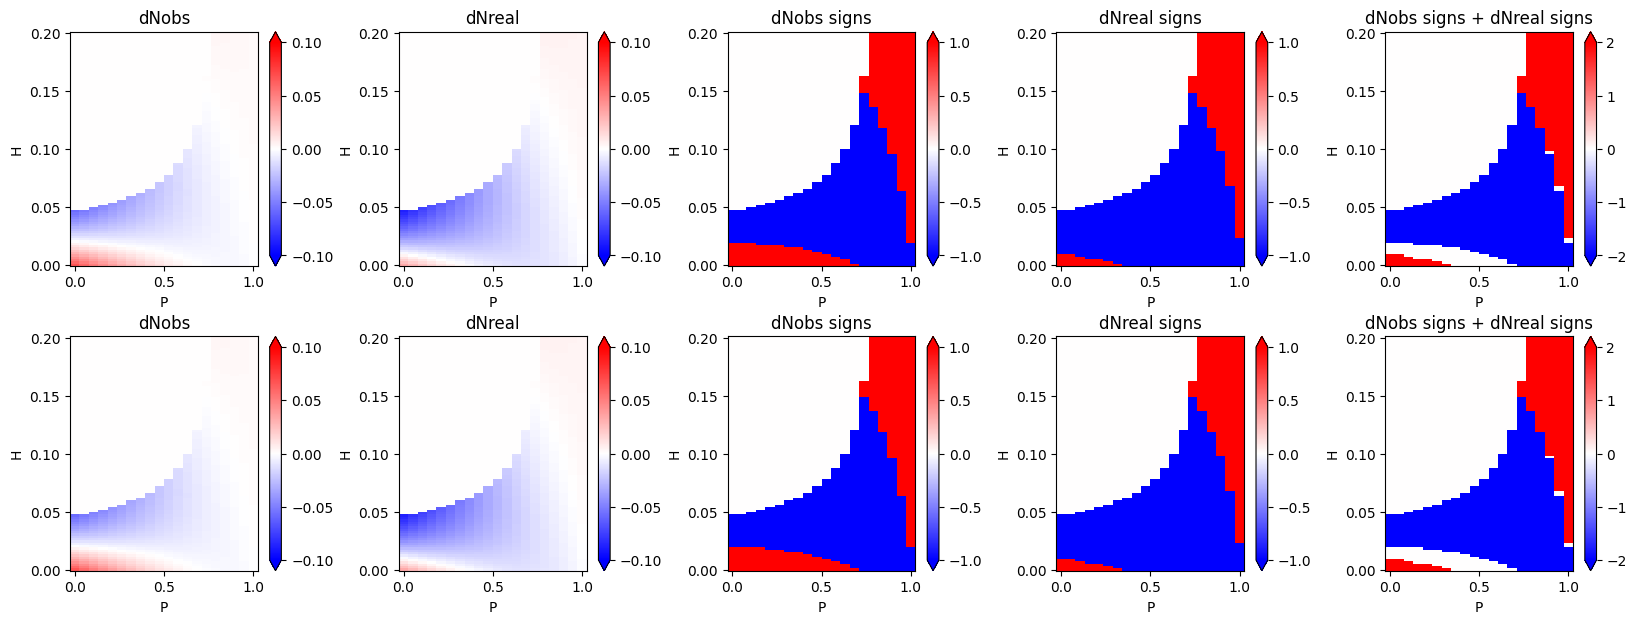

In [ ]:
# plotting

if False:
    plots_ana = [
        dNobs,
        dNreal,
        dNobs_signs,
        dNreal_signs,
        dNobs_dNreal_comparison,
    ]  # analytical solutions
    plots_num = [
        dNobs_num,
        dNreal_num,
        dNobs_signs_num,
        dNreal_signs_num,
        dNobs_dNreal_comparison_num,
    ]  # numerical solutions
    titles = [
        "dNobs",
        "dNreal",
        "dNobs signs",
        "dNreal signs",
        "dNobs signs + dNreal signs",
    ]

    fig, axs = plt.subplots(2, 5, figsize=(20, 7))
    fig.subplots_adjust(hspace=0.3, wspace=0.4)
    cmaps = ["bwr", "bwr", "bwr", "bwr", "bwr"]
    clims = [(-0.1, 0.1), (-0.1, 0.1), (-1, 1), (-1, 1), (-2, 2)]

    for j, plots in enumerate(
        [plots_ana, plots_num]
    ):  # first row analytical, second row numerical
        for i, col in enumerate(cmaps):
            ax = axs[j, i]
            cmap = plt.get_cmap(col)
            cmap.set_bad(color="green", alpha=1.0)  # set color for NaN values
            ax.set_xlabel("P")
            ax.set_ylabel("H")
            pcm = ax.pcolormesh(Ps, Hs, plots[i], cmap=cmap)  # plot the data
            pcm.set_clim(clims[i])
            fig.colorbar(pcm, ax=axs[j, i], shrink=1, extend="both")
            ax.set_title(titles[i])

    plt.show()

## Compare Nobs and Nreal (not derivatives)

In [ ]:
Nobs_vals = np.zeros((len(Hs), len(Ps)))
Nreal_vals = np.zeros((len(Hs), len(Ps)))
Nobs_Nreal_vals_comparison = np.zeros((len(Hs), len(Ps)))

for i, H in enumerate(Hs):
    for j, P in enumerate(Ps):
        Nobs_vals[i, j] = Nobs(P, H)
        Nreal_vals[i, j] = Nreal(P, H)
        Nobs_Nreal_vals_comparison[i, j] = Nobs_vals[i, j] - Nreal_vals[i, j]

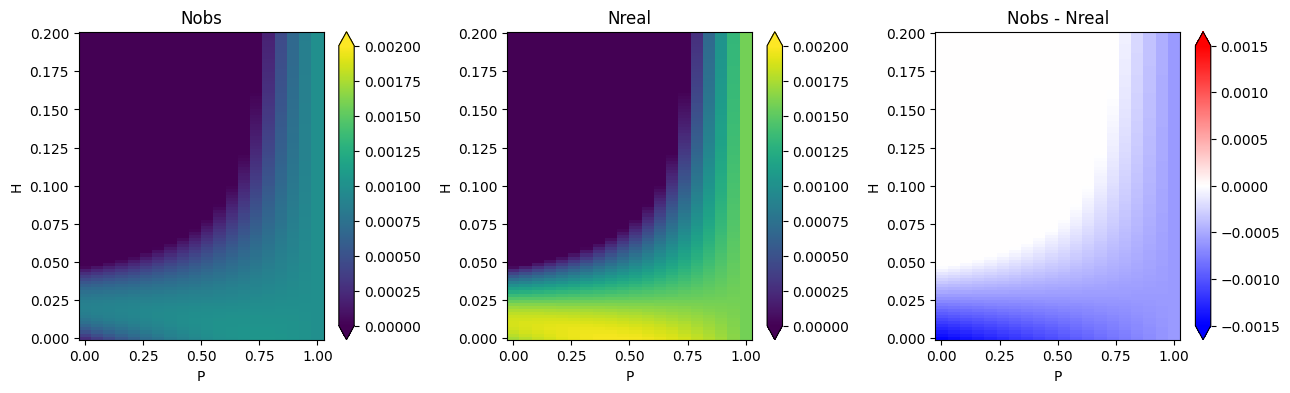

In [ ]:
# plotting

if False:
    plots = [Nobs_vals, Nreal_vals, Nobs_Nreal_vals_comparison]
    titles = ["Nobs", "Nreal", "Nobs - Nreal"]

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    fig.subplots_adjust(hspace=0.3, wspace=0.4)
    cmaps = ["viridis", "viridis", "bwr"]
    clims = [(0, 0.002), (0, 0.002), (-0.0015, 0.0015)]

    for i, col in enumerate(cmaps):
        ax = axs[i]
        cmap = plt.get_cmap(col)
        cmap.set_bad(color="green", alpha=1.0)  # set color for NaN values
        ax.set_xlabel("P")
        ax.set_ylabel("H")
        pcm = ax.pcolormesh(Ps, Hs, plots[i], cmap=cmap)  # plot the data
        pcm.set_clim(clims[i])
        fig.colorbar(pcm, ax=axs[i], shrink=1, extend="both")
        ax.set_title(titles[i])

    plt.show()

## Saving data for plots

In [6]:
# save stuff as npy files

with open(
    "../results/Nreal_Nobs_values_and_derivatives_lambdap%g_betaSTI%g.npy"
    % (lambdaP * 360, betaSTI),
    "wb",
) as f:
    np.save(f, Ps)
    np.save(f, Hs)
    np.save(f, dNobsdP)
    np.save(f, dNobsdH)
    np.save(f, dNrealdP)
    np.save(f, dNrealdH)
    np.save(f, Nobs_vals)
    np.save(f, Nreal_vals)

NameError: name 'Nobs_vals' is not defined

## Final plot

(101, 201)
N min:  0.0 , N max:  197.4799320182212
rounded N min:  0 , rounded N max:  200
Ndiff min:  0.0 , Ndiff max:  146.82247778401955
rounded Ndiff min:  0 , rounded Ndiff max:  150
dNdP min:  -0.0014048581017027466 , dNdP max:  0.008962396639829557
rounded dNdP min:  -0.0015 , rounded dNdP max:  0.009
dNdH min:  -0.08819869610912771 , dNdH max:  0.06449565284423281
rounded dNdH min:  -0.09 , rounded dNdH max:  0.07


C:\Users\PMallick\AppData\Local\Temp\ipykernel_28568\2226819679.py:393: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


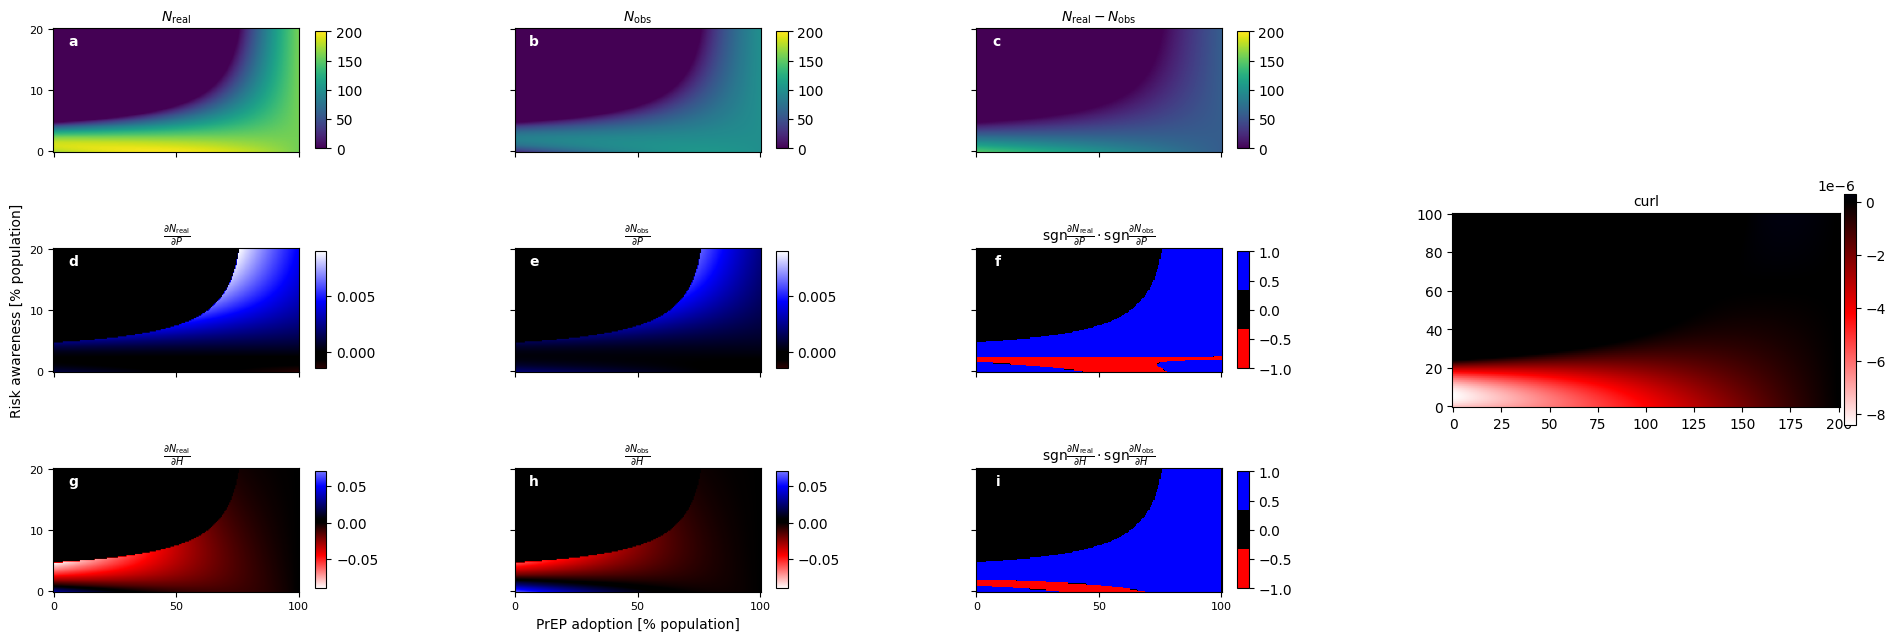

In [14]:
with open(
    "../results/Nreal_Nobs_values_and_derivatives_lambdap%g_betaSTI%g.npy"
    % (lambdaP * 360, betaSTI),
    "rb",
) as f:


    Ps_plot = np.load(f)


    Hs_plot = np.load(f)


    dNobsdP_plot = np.load(f)


    dNobsdH_plot = np.load(f)


    dNrealdP_plot = np.load(f)


    dNrealdH_plot = np.load(f)


    Nobs_plot = np.load(f) * 100000


    Nreal_plot = np.load(f) * 100000



Nreal_minus_Nobs_plot = Nreal_plot - Nobs_plot


signs_dNdP_plot = np.multiply(np.sign(dNobsdP_plot), np.sign(dNrealdP_plot))


signs_dNdH_plot = np.multiply(np.sign(dNobsdH_plot), np.sign(dNrealdH_plot))



results = [
    [Nreal_plot, Nobs_plot, Nreal_minus_Nobs_plot],
    [dNrealdP_plot, dNobsdP_plot, signs_dNdP_plot],
    [dNrealdH_plot, dNobsdH_plot, signs_dNdH_plot],
]



print(np.shape(results[0][0]))



titles = [
    [r"$N_{\text{real}}$", r"$N_{\text{obs}}$", r"$N_{\text{real}}-N_{\text{obs}}$"],
    [
        r"$\frac{\partial N_{\text{real}}}{\partial P}$",
        r"$\frac{\partial N_{\text{obs}}}{\partial P}$",
        r"$\text{sgn}\frac{\partial N_{\text{real}}}{\partial P}\cdot\text{sgn}\frac{\partial N_{\text{obs}}}{\partial P}$",
    ],
    [
        r"$\frac{\partial N_{\text{real}}}{\partial H}$",
        r"$\frac{\partial N_{\text{obs}}}{\partial H}$",
        r"$\text{sgn}\frac{\partial N_{\text{real}}}{\partial H}\cdot\text{sgn}\frac{\partial N_{\text{obs}}}{\partial H}$",
    ],
]



min_N = np.min(np.concatenate((Nobs_plot, Nreal_plot)))


max_N = np.max(np.concatenate((Nobs_plot, Nreal_plot)))


min_Ndiff = np.min(Nreal_minus_Nobs_plot)


max_Ndiff = np.max(Nreal_minus_Nobs_plot)


min_dNdP = np.min(np.concatenate((dNobsdP_plot, dNrealdP_plot)))


max_dNdP = np.max(np.concatenate((dNobsdP_plot, dNrealdP_plot)))


min_dNdH = np.min(np.concatenate((dNobsdH_plot, dNrealdH_plot)))


max_dNdH = np.max(np.concatenate((dNobsdH_plot, dNrealdH_plot)))



# rounded values for custom colorbars
min_N_rounded = 0


max_N_rounded = 200
min_Ndiff_rounded = 0


max_Ndiff_rounded = 150


min_dNdP_rounded = -0.0015


max_dNdP_rounded = 0.009


min_dNdH_rounded = -0.09


max_dNdH_rounded = 0.07



# print to see if everything is correct


print("N min: ", min_N, ", N max: ", max_N)


print("rounded N min: ", min_N_rounded, ", rounded N max: ", max_N_rounded)


print("Ndiff min: ", min_Ndiff, ", Ndiff max: ", max_Ndiff)


print(
    "rounded Ndiff min: ", min_Ndiff_rounded, ", rounded Ndiff max: ", max_Ndiff_rounded
)


print("dNdP min: ", min_dNdP, ", dNdP max: ", max_dNdP)


print("rounded dNdP min: ", min_dNdP_rounded, ", rounded dNdP max: ", max_dNdP_rounded)


print("dNdH min: ", min_dNdH, ", dNdH max: ", max_dNdH)


print("rounded dNdH min: ", min_dNdH_rounded, ", rounded dNdH max: ", max_dNdH_rounded)



minlims = [
    [min_N_rounded, min_N_rounded, min_N_rounded],
    [min_dNdP_rounded, min_dNdP_rounded, -1],
    [min_dNdH_rounded, min_dNdH_rounded, -1],
]


maxlims = [
    [max_N_rounded, max_N_rounded, max_N_rounded],
    [max_dNdP_rounded, max_dNdP_rounded, 1],
    [max_dNdH_rounded, max_dNdH_rounded, 1],
]



def tuplearraycreator(stepsred, stepsblue):


    colorsred = []


    colorsblue = []


    if stepsred % 2 != 0 or stepsblue % 2 != 0:


        stepsred *= 2


        stepsblue *= 2


    if stepsred > stepsblue:
        stepcounter = 0


        for i in range(stepsred // 2 + 1):


            ratio = i / (stepsred / 2)
            colorsred.append((ratio, 0, 0))


            if stepcounter < stepsblue:


                colorsblue.append((0, 0, ratio))


                stepcounter += 1


        for i in range(stepsred // 2):


            ratio = (i + 1) / (stepsred / 2)


            colorsred.append((1, ratio, ratio))


            if stepcounter < stepsblue:


                colorsblue.append((ratio, ratio, 1))


                stepcounter += 1


    else:
        stepcounter = 0


        for i in range(stepsblue // 2 + 1):


            ratio = i / (stepsblue / 2)


            colorsblue.append((0, 0, ratio))


            if stepcounter < stepsred:
                colorsred.append((ratio, 0, 0))


                stepcounter += 1


        for i in range(stepsblue // 2):


            ratio = (i + 1) / (stepsblue / 2)


            colorsblue.append((ratio, ratio, 1))


            if stepcounter < stepsred:


                colorsred.append((1, ratio, ratio))


                stepcounter += 1


    total = np.concatenate((colorsred[::-1], colorsblue))


    # print(total)
    return total



cmap_dNdP = mpl.colors.LinearSegmentedColormap.from_list(
    "my_cmap", tuplearraycreator(2, 12), N=4 * 256
)


cmap_dNdH = mpl.colors.LinearSegmentedColormap.from_list(
    "my_cmap2", tuplearraycreator(9, 7), N=4 * 256
)


cmap_signs = mpl.colors.ListedColormap(["r", "k", "b"])


bounds = [-1, 0, 1]


norm = mpl.colors.BoundaryNorm(bounds, cmap_signs.N)



cmaps = [
    ["viridis", "viridis", "viridis"],
    [cmap_dNdP, cmap_dNdP, cmap_signs],
    [cmap_dNdH, cmap_dNdH, cmap_signs],
]



# colors = plt.cm.viridis(np.linspace(0, 1, len(lambda_P_values_2)))


# colors_stability = ["#E9002D", "#FFAA00", "#00B000"]



# Combined plotting


fig = plt.figure(figsize=(8.0 * 3, 3 * 2.5))


outer_grid = fig.add_gridspec(1, 2, width_ratios=[4, 1.5], wspace=0.2)


grid = outer_grid[0].subgridspec(3, 3, wspace=0.5, hspace=0.6)



axes = []


for i in range(3):


    row_axes = []


    for j in range(3):


        ax = fig.add_subplot(grid[i, j])


        row_axes.append(ax)


    axes.append(row_axes)



for i in [0, 1, 2]:


    for j in [0, 1, 2]:


        ax = axes[i][j]


        result = results[i][j]


        cax = ax.imshow(
            result,
            origin="lower",
            cmap=cmaps[i][j],
            vmin=minlims[i][j],
            vmax=maxlims[i][j],
        )


        cbar = fig.colorbar(cax, ax=ax, aspect=10, shrink=0.85, pad=0.05)


        # if i == 0 and j == 2:


        # cbar.ax.set_ylabel("New daily infections [per 100,000]", fontsize=9)


        ax.set_title(f"{titles[i][j]}", fontsize=10, pad=5)


        if i == 2:


            ax.set_xticks([0, 100, 200])


            ax.set_xticklabels(
                [
                    int(Ps_plot[0] * 100),
                    int(Ps_plot[100] * 100),
                    int(Ps_plot[200] * 100),
                ],
                fontsize=8,
            )


        else:


            ax.set_xticks([0, 100, 200])


            ax.set_xticklabels([])


        if j == 0:


            ax.set_yticks([0, 50, 100])


            ax.set_yticklabels(
                [
                    int(Hs_plot[0] * 100),
                    int(Hs_plot[50] * 100),
                    int(Hs_plot[100] * 100),
                ],
                fontsize=8,
            )


        else:


            ax.set_yticks([0, 50, 100])


            ax.set_yticklabels([])


        if i == 1 and j == 0:


            ax.set_ylabel("Risk awareness [% population]", fontsize=10)


        if i == 2 and j == 1:


            ax.set_xlabel("PrEP adoption [% population]", fontsize=10)



# Add subpanel letters


for idx, ax in enumerate([ax for row_axes in axes for ax in row_axes]):
    ax.text(

        0.1,
        0.95,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=10,
        fontweight="bold",
        va="top",
        ha="right",
        color="white",
    )



# second part, curl


ax = fig.add_subplot(outer_grid[1])



curl = dNobsdP_plot * dNrealdH_plot - dNobsdH_plot * dNrealdP_plot
curl_min = np.min(curl)
curl_max = np.max(curl)


# print("curl min: ", curl_min, ", curl max: ", curl_max)


cax = ax.imshow(
    curl,
    origin="lower",
    cmap=mpl.colors.LinearSegmentedColormap.from_list(
        "my_cmapcurl", tuplearraycreator(85, 3), N=4 * 256
    ),
    vmin=curl_min,
    vmax=curl_max,
)


cbar = fig.colorbar(cax, ax=ax, shrink=0.4, pad=0.01)


# cbar.ax.set_ylabel("New daily infections [per 100,000]", fontsize=9)


ax.set_title("curl", fontsize=10, pad=5)



plt.tight_layout()


plt.show()



fig.savefig("../figures/final_figure_Nobs_Nreal.pdf", format="pdf", bbox_inches="tight")

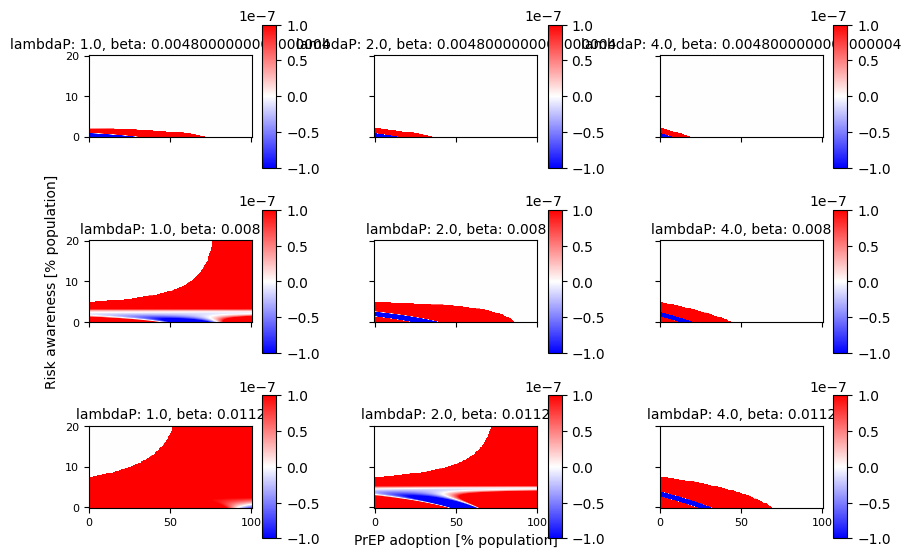

In [17]:
# dNrealdP * dNobsdP for different beta and lambdaP values

lambdaP_values = [1 / 360, 2 / 360, 4 / 360]
betaSTI_values = [0.0016 * 3, 0.0016 * 5, 0.0016 * 7]
Ps = np.linspace(0, 1, 201)
Hs = np.linspace(0, 0.2, 101)
results = [[], [], []]

for i, betaSTI in enumerate(betaSTI_values):
    res = []
    for lambdaP in lambdaP_values:
        with open(
            "../results/Nreal_Nobs_values_and_derivatives_lambdap%g_betaSTI%g.npy"
            % (lambdaP * 360, betaSTI),
            "rb",
        ) as f:
            Ps_plot = np.load(f)
            Hs_plot = np.load(f)
            dNobsdP_plot = np.load(f)
            dNobsdH_plot = np.load(f)
            dNrealdP_plot = np.load(f)
            dNrealdH_plot = np.load(f)
            Nobs_plot = np.load(f) * 100000
            Nreal_plot = np.load(f) * 100000
        x = dNrealdP_plot * dNobsdP_plot
        # print(lambdaP, betaSTI, np.min(x), np.max(x))
        res.append(x)
    results[i] = res

fig, axs = plt.subplots(3, 3, figsize=(10, 7))
fig.subplots_adjust(hspace=0.1, wspace=0.4)
minlims = [[-6e-7, -2e-7, -8e-8], [-3e-6, -8e-7, -4e-7], [-9e-6, -3e-6, -2e-6]]
maxlims = [[6e-6, 6e-5, 9e-5], [3e-5, 3e-5, 5e-5], [9e-5, 1e-4, 1e-4]]
cmap_1 = mpl.colors.LinearSegmentedColormap.from_list(
    "my_cmap", tuplearraycreator(6, 60), N=4 * 256
)
cmap_2 = mpl.colors.LinearSegmentedColormap.from_list(
    "my_cmap2", tuplearraycreator(2, 600), N=4 * 256
)
cmap_3 = mpl.colors.LinearSegmentedColormap.from_list(
    "my_cmap3", tuplearraycreator(8, 9000), N=4 * 256
)
cmap_4 = mpl.colors.LinearSegmentedColormap.from_list(
    "my_cmap3", tuplearraycreator(3, 30), N=4 * 256
)
smap_5 = mpl.colors.LinearSegmentedColormap.from_list(
    "my_cmap3", tuplearraycreator(8, 300), N=4 * 256
)
cmap_6 = mpl.colors.LinearSegmentedColormap.from_list(
    "my_cmap3", tuplearraycreator(4, 500), N=4 * 256
)
cmap_7 = mpl.colors.LinearSegmentedColormap.from_list(
    "my_cmap3", tuplearraycreator(9, 90), N=4 * 256
)
cmap_8 = mpl.colors.LinearSegmentedColormap.from_list(
    "my_cmap3", tuplearraycreator(3, 100), N=4 * 256
)
cmap_9 = mpl.colors.LinearSegmentedColormap.from_list(
    "my_cmap3", tuplearraycreator(2, 100), N=4 * 256
)
# cmaps = [[cmap_1, cmap_2, cmap_3], [cmap_4, smap_5, cmap_6], [cmap_7, cmap_8, cmap_9]]
cmaps = [["bwr", "bwr", "bwr"], ["bwr", "bwr", "bwr"], ["bwr", "bwr", "bwr"]]

for i, betaSTI in enumerate(betaSTI_values):
    for j, lambdaP in enumerate(lambdaP_values):
        ax = axs[i, j]
        result = results[i][j]
        cax = ax.imshow(
            result,
            origin="lower",
            cmap=cmaps[i][j],
            vmin=-1e-7,
            vmax=1e-7,
        )
        cbar = fig.colorbar(cax, ax=ax, aspect=10, shrink=0.85, pad=0.05)
        ax.set_title(f"lambdaP: {lambdaP*360}, beta: {betaSTI}", fontsize=10, pad=5)
        if i == 2:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels(
                [
                    int(Ps_plot[0] * 100),
                    int(Ps_plot[100] * 100),
                    int(Ps_plot[200] * 100),
                ],
                fontsize=8,
            )
        else:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels([])

        if j == 0:
            ax.set_yticks([0, 50, 100])
            ax.set_yticklabels(
                [
                    int(Hs_plot[0] * 100),
                    int(Hs_plot[50] * 100),
                    int(Hs_plot[100] * 100),
                ],
                fontsize=8,
            )
        else:
            ax.set_yticks([0, 50, 100])
            ax.set_yticklabels([])

        if i == 1 and j == 0:
            ax.set_ylabel("Risk awareness [% population]", fontsize=10)
        if i == 2 and j == 1:
            ax.set_xlabel("PrEP adoption [% population]", fontsize=10)

## Final figure

C:\Users\PMallick\AppData\Local\Temp\ipykernel_17476\1904305308.py:231: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


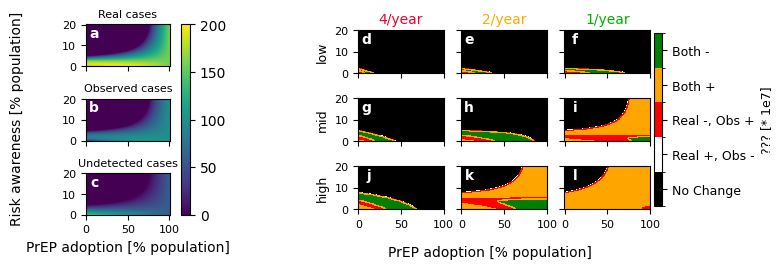

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors


# First figure data generation (3x3)
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1.0, 201)

lambda_P_values = [4 / 360.0, 2 / 360.0, 1 / 360.0]
lambda_P_labels = ["4/year", "2/year", "1/year"]
beta_STI_values = [0.0016 * 3.0, 0.0016 * 5.0, 0.0016 * 7.0]
beta_STI_labels = ["low", "mid", "high"]
colors_stability = ["#E9002D", "#FFAA00", "#00B000"]

# Combined plotting
fig = plt.figure(figsize=(8.0, 2.5))

# Adjust width ratios to control the size of the panels
outer_grid = fig.add_gridspec(1, 2, width_ratios=[0.8, 2.5], wspace=0.7)

# First subplot grid (3x1)
left_grid = outer_grid[0].subgridspec(3, 1, hspace=0.7)
with open(
    "../results/Nreal_Nobs_values_and_derivatives_lambdap%g_betaSTI%g.npy" % (1, 0.008),
    "rb",
) as f:
    Ps_plot = np.load(f)
    Hs_plot = np.load(f)
    dNobsdP_plot = np.load(f)
    dNobsdH_plot = np.load(f)
    dNrealdP_plot = np.load(f)
    dNrealdH_plot = np.load(f)
    Nobs_plot = np.load(f) * 100000
    Nreal_plot = np.load(f) * 100000


Nreal_minus_Nobs_plot = Nreal_plot - Nobs_plot
results = [Nreal_plot, Nobs_plot, Nreal_minus_Nobs_plot]
titles = ["Real cases", "Observed cases", "Undetected cases"]

axs = []
for i in range(3):
    ax = fig.add_subplot(left_grid[i])
    axs.append(ax)


for i, ax in enumerate(axs):
    for color in colors_stability:
        cax = ax.imshow(
            results[i],
            origin="lower",
            vmin=0,
            vmax=200,
            cmap="viridis",
        )
        ax.set_title(titles[i], fontsize=8, pad=5)
    
    if i == 2:
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels([int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8)
        ax.set_xlabel("PrEP adoption [% population]", fontsize=10)
    else:
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels([])
    ax.set_yticks([0, 50, 100])
    ax.set_yticklabels(
        [int(Hs[0] * 100), int(Hs[50] * 100), int(Hs[100] * 100)], fontsize=8
    )

cbar = fig.colorbar(cax, ax=axs, shrink=0.99, pad=0.1)
# for ax in axs[:-1]:
#     ax.set_xticklabels([])

# legend.get_frame().set_facecolor("white")
# legend.get_frame().set_alpha(1)

for idx, ax in enumerate(axs):
    ax.text(
        0.15,
        0.95,
        chr(97 + idx),
        transform=ax.transAxes,
        fontsize=10,
        fontweight="bold",
        va="top",
        ha="right",
        color="white",
    )

results = [[], [], []]

for i, betaSTI in enumerate(beta_STI_values):
    res = []
    for lambdaP in lambda_P_values:
        with open(
            "../results/Nreal_Nobs_values_and_derivatives_lambdap%g_betaSTI%g.npy"
            % (lambdaP * 360, betaSTI),
            "rb",
        ) as f:
            Ps_plot = np.load(f)
            Hs_plot = np.load(f)
            dNobsdP_plot = np.load(f)
            dNobsdH_plot = np.load(f)
            dNrealdP_plot = np.load(f)
            dNrealdH_plot = np.load(f)
            Nobs_plot = np.load(f) * 100000
            Nreal_plot = np.load(f) * 100000
        x = dNrealdP_plot * dNobsdP_plot
        real_positive_obs_negative = np.where((dNrealdP_plot > 0) & (dNobsdP_plot < 0), 1, 0)
        real_negative_obs_positive = np.where((dNrealdP_plot < 0) & (dNobsdP_plot > 0), 10, 0)
        both_positive = np.where((dNrealdP_plot > 0) & (dNobsdP_plot > 0), 100, 0)
        both_negative = np.where((dNrealdP_plot < 0) & (dNobsdP_plot < 0), 1000, 0)
        variable_to_plot = real_positive_obs_negative + real_negative_obs_positive + both_positive + both_negative
        # print(lambdaP, betaSTI, np.min(x), np.max(x))
        #res.append(x)
        res.append(variable_to_plot)
    results[i] = res

#print(dNrealdP_plot)
#print(f"Real +: {real_positive_obs_negative}")
#print(f"Real -: {real_negative_obs_positive}")
#print(variable_to_plot.shape)
global_vmin = -1e-7
global_vmax = 1e-7

cmap = mcolors.ListedColormap(['black', 'white', 'red', 'orange', 'green'])
bounds = [0, 1, 10, 100, 1000, 1001]
norm = mcolors.BoundaryNorm(bounds, cmap.N)
# Second subplot grid (3x3)
right_grid = outer_grid[1].subgridspec(3, 3, wspace=0.2, hspace=0.2)
axes = []
for i in range(3):
    row_axes = []
    for j in range(3):
        ax = fig.add_subplot(right_grid[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

for row_idx, beta_STI in enumerate(beta_STI_values):
    for col_idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
        ax = axes[row_idx][col_idx]
        cax = ax.imshow(
            results[row_idx][col_idx],
            origin="lower",
            cmap=cmap,
            norm=norm,
        )
        ax.set_xticks([0, 100, 200])
        ax.set_xticklabels(
            [int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8
        )
        ax.set_yticks([0, 50, 100])
        ax.set_yticklabels(
            [int(Hs[0] * 100), int(Hs[50] * 100), int(Hs[100] * 100)], fontsize=8
        )

        if row_idx == 0:
            ax.set_title(
                f"{label}", fontsize=10, pad=5, color=colors_stability[col_idx]
            )
        if col_idx == 0:
            ax.set_ylabel(f"{beta_STI_labels[row_idx]}", fontsize=9)

        # ax.hlines(np.where(Hs == 0.05)[0][0], 0, 200, color="black", linestyle="--")

        if row_idx == 2:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels(
                [int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8
            )
        else:
            ax.set_xticks([0, 100, 200])
            ax.set_xticklabels([])

        if col_idx == 0:
            ax.set_yticks([0, 50, 100])
            ax.set_yticklabels(
                [int(Hs[0] * 100), int(Hs[50] * 100), int(Hs[100] * 100)], fontsize=8
            )
        else:
            ax.set_yticks([0, 50, 100])
            ax.set_yticklabels([])

# Add subpanel letters
for idx, ax in enumerate([ax for row_axes in axes for ax in row_axes]):
    ax.text(
        0.15,
        0.95,
        chr(97 + 3 + idx),
        transform=ax.transAxes,
        fontsize=10,
        fontweight="bold",
        va="top",
        ha="right",
        color="white",
    )

# Color bar for first subplot
tick_locs = [(bounds[i] + bounds[i+1]) / 2 for i in range(len(bounds)-1)]
#cbar.set_ticks(tick_locs)
cbar = fig.colorbar(
    cax,
    ax=[ax for row_axes in axes for ax in row_axes],
    shrink=0.9,
    #format=FuncFormatter(lambda x, pos: f"{x * 1e7:.0f}"),
    pad=0.01,
    #extend="both",
    ticks=tick_locs,
)
# Get existing ticks and replace the last value with global_vmax
# ticks = cbar.get_ticks()
# ticks[-1] = global_vmax
# cbar.set_ticks(ticks)

cbar.ax.set_yticklabels(["No Change", "Real +, Obs -", "Real -, Obs +", "Both +", "Both -"], fontsize=9)
cbar.ax.set_ylabel("??? [* 1e7]", fontsize=9)

fig.text(0.63, -0.05, "PrEP adoption [% population]", ha="center", fontsize=10)
fig.text(
    0.03,
    0.5,
    "Risk awareness [% population]",
    va="center",
    rotation="vertical",
    fontsize=10,
)
#fig.text(0.067, 0.07, "$\\beta_{{STI}}$ =", va="center", rotation="vertical", fontsize=9)

plt.tight_layout()
plt.show()

#fig.savefig("../figures/final_figureDERIVATIVES.pdf", format="pdf", bbox_inches="tight")